# Luderick Object Detection Using YOLOv5

## Load the preprocessed DataFrames generated in the preprocessing Notebook

In [56]:
# all imports
import pandas as pd
import numpy as np
import torch
import ast
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

In [3]:
def load_luderick_df(file_path):
    """
    Loads a preprocessed luderick dataframe from a .csv and converts its 
    array column from string to a proper array
    """
    loaded_df = pd.read_csv(file_path)
    loaded_df['labels'] = loaded_df['labels'].apply(lambda x: ast.literal_eval(x))
    loaded_df['bounding_boxes'] = loaded_df['bounding_boxes'].apply(lambda x: ast.literal_eval(x))
    loaded_df['area'] = loaded_df['area'].apply(lambda x: ast.literal_eval(x))
    loaded_df['segmentation'] = loaded_df['segmentation'].apply(lambda x: ast.literal_eval(x))
    
    return loaded_df

In [4]:
train_df = load_luderick_df('luderick_train_preprocessed.csv')
validation_df = load_luderick_df('luderick_validation_preprocessed.csv')

train_df

image_name       video_name  frame_number  \
0     04C1_Luderick_1.mov_5fps_000001.jpg  04C1_Luderick_1             1   
1     04C1_Luderick_1.mov_5fps_000002.jpg  04C1_Luderick_1             2   
2     04C1_Luderick_1.mov_5fps_000003.jpg  04C1_Luderick_1             3   
3     04C1_Luderick_1.mov_5fps_000004.jpg  04C1_Luderick_1             4   
4     04C1_Luderick_1.mov_5fps_000005.jpg  04C1_Luderick_1             5   
...                                   ...              ...           ...   
2667             C4_Luderick_9_014000.jpg    C4_Luderick_9            21   
2668             C4_Luderick_9_014200.jpg    C4_Luderick_9            22   
2669             C4_Luderick_9_014400.jpg    C4_Luderick_9            23   
2670             C4_Luderick_9_014600.jpg    C4_Luderick_9            24   
2671             C4_Luderick_9_014800.jpg    C4_Luderick_9            25   

      number_boxes labels            bounding_boxes      area  \
0                1    [1]  [[1778, 425, 1919, 610]]   [26085]   
1                1    [1]  [[1659, 406, 1919, 645]]   [62140]   
2                1    [1]  [[1578, 400, 1915, 620]]   [74140]   
3                1    [1]  [[1508, 398, 1812, 626]]   [69312]   
4                1    [1]  [[1465, 390, 1699, 626]]   [55224]   
...            ...    ...                       ...       ...   
2667             1    [1]    [[471, 127, 699, 360]]   [53124]   
2668             1    [1]     [[561, 79, 829, 313]]   [62712]   
2669             1    [1]     [[573, 33, 971, 261]]   [90744]   
2670             1    [1]     [[650, 3, 1126, 216]]  [101388]   
2671             1    [1]     [[797, 6, 1286, 184]]   [87042]   

                                           segmentation  
0     [[1778, 515, 1789, 498, 1806, 479, 1835, 457, ...  
1     [[1659, 509, 1675, 488, 1696, 465, 1720, 437, ...  
2     [[1578, 530, 1585, 512, 1594, 496, 1592, 477, ...  
3     [[1812, 624, 1795, 578, 1795, 542, 1797, 507, ...  
4     [[1691, 591, 1687, 544, 1688, 503, 1691, 473, ...  
...                                                 ...  
2667  [[471, 360, 491, 319, 492, 280, 487, 236, 489,...  
2668  [[578, 313, 592, 247, 618, 252, 656, 230, 679,...  
2669  [[578, 261, 594, 213, 601, 183, 594, 146, 581,...  
2670  [[650, 216, 676, 182, 673, 133, 674, 90, 673, ...  
2671  [[797, 184, 811, 150, 822, 123, 811, 70, 800, ...  

[2672 rows x 8 columns]

## Constants

In [66]:
BATCH_SIZE = 2 # increase / decrease according to GPU memeory
#MAX_SIZE = 512 # resize the image for training and transforms
NUM_EPOCHS = 20 # number of epochs to train for

IMAGES_DIR = os.path.join("Fish_automated_identification_and_counting", "luderick-seagrass")

# classes: 0 index is reserved for background
CLASSES = ['background', 'Luderick']
NUM_CLASSES = len(CLASSES)

# location to save model and plots
OUT_DIR = 'YOLOv5_outputs'
!mkdir {OUT_DIR}

Ya existe el subdirectorio o el archivo YOLOv5_outputs.


## Prepare the Dataset in the YOLO format

YOLO wants the following folder structure in the same folder of the yolov5 repository:


In [5]:
# datasets
#  │
#  └─ luderick
#     ├─ images
#     │   ├── train
#     │   │   ├── IMG_1.jpg
#     │   │   ...
#     │   │   └── IMG_X.jpg
#     │   │   
#     │   └── validation
#     │       ├── IMG_1.jpg
#     │       ...
#     │       └── IMG_X.jpg
#     │  
#     │
#     └── labels
#         ├── train
#         │   ├── IMG_1.txt
#         │   ...
#         │   └── IMG_X.txt
#         │   
#         └── validation
#             ├── IMG_1.txt
#             ...
#             └── IMG_X.txt

Annotation (labels) should have the following format:

* One row per object
* Each row is class x_center y_center width height format.
* Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
* Class numbers are zero-indexed (start from 0).

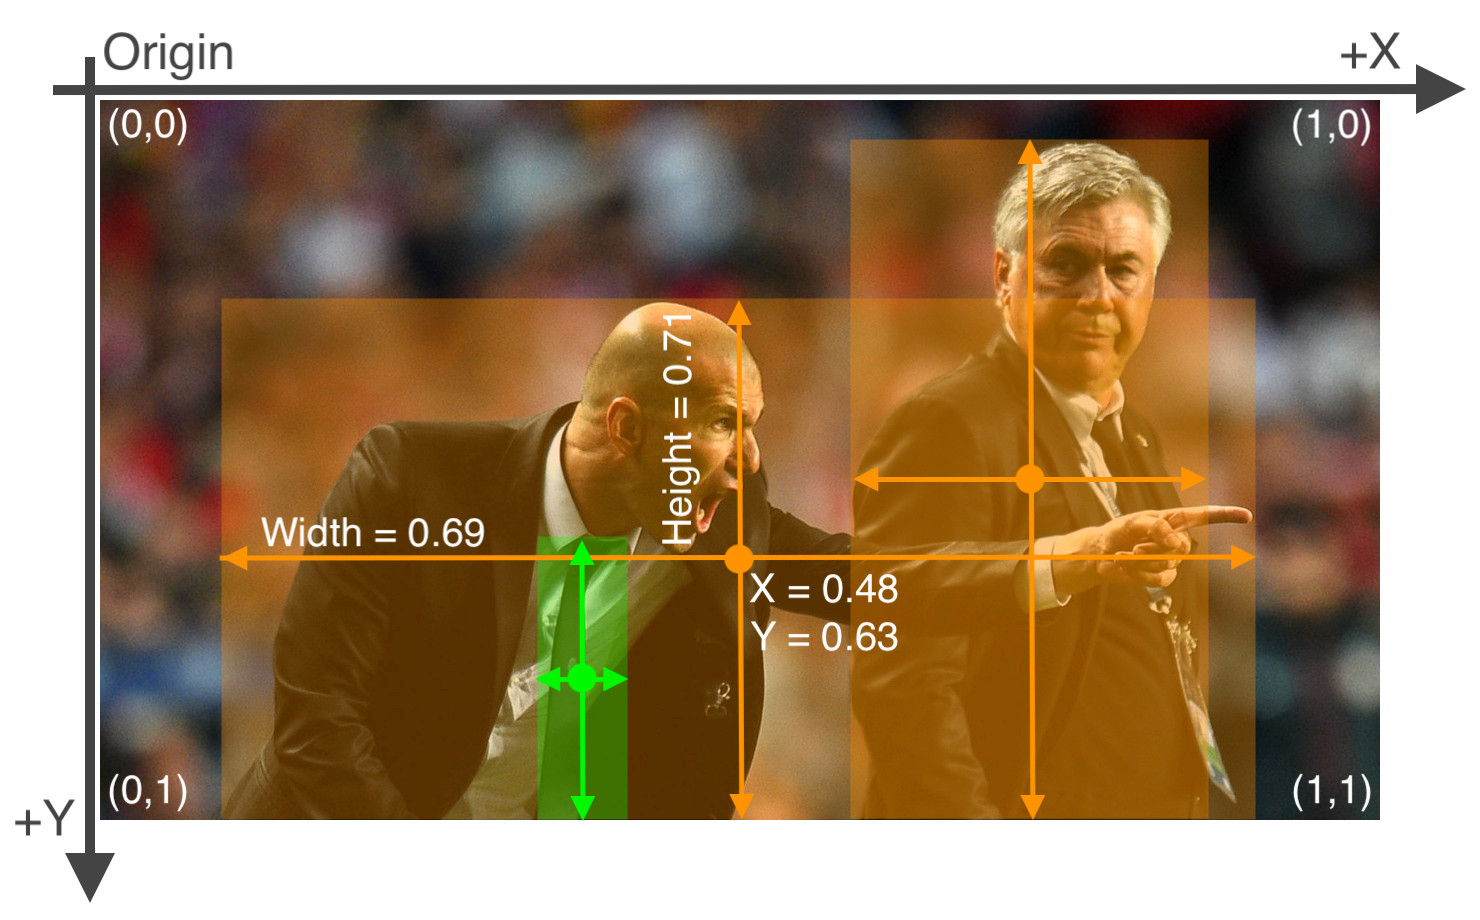

The label file corresponding to the above image contains 2 persons (class 0) and a tie (class 27):

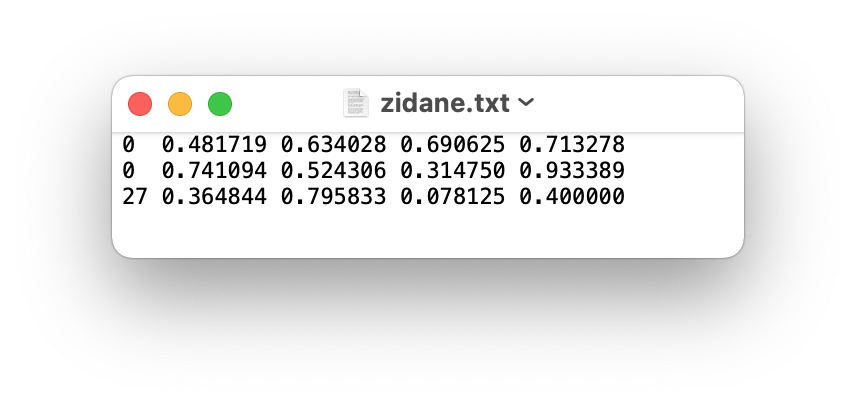

In [12]:
# Create folders

!mkdir datasets
%cd datasets
!mkdir luderick
%cd luderick
!mkdir images
!mkdir labels
%cd images
!mkdir train
!mkdir validation
!mkdir test
%cd ../labels
!mkdir train
!mkdir validation
!mkdir test
%cd ../../..

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\datasets
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\datasets\luderick
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\datasets\luderick\images
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\datasets\luderick\labels
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass


In [73]:
sep = os.sep
img_out_path = f"datasets{sep}luderick{sep}images{sep}tain"
img_out_path

'datasets\\luderick\\images\\tain'

In [ ]:
# Copy images and create .txt annotations

sep = os.sep
img_out_path = f"datasets{sep}luderick{sep}images{sep}tain"
for index, row in train_df.iterrows():
    image_path = os.path.join(IMAGES_DIR, row['image_name'])
    image = Image.open(image_path).size
    boxes = np.array(row['bounding_boxes'])
    image_name = row['image_name']
    for i, box in enumerate(boxes):
        with open('workfile') as f:

In [29]:
row = train_df.iloc[90]
row

image_name                      04C1_Luderick_2.mov_5fps_000089.jpg
video_name                                          04C1_Luderick_2
frame_number                                                     50
number_boxes                                                      7
labels                                        [1, 1, 1, 1, 1, 1, 1]
bounding_boxes    [[505, 830, 1427, 1075], [1356, 496, 1560, 786...
area              [225890, 59160, 318240, 34958, 89726, 9225, 12...
segmentation      [[505, 957, 551, 898, 655, 861, 793, 847, 918,...
Name: 90, dtype: object

In [28]:
np.array(row['bounding_boxes']) / 10

array([[ 50.5,  83. , 142.7, 107.5],
       [135.6,  49.6, 156. ,  78.6],
       [143.1,   8.7, 191.1,  75. ],
       [ 68.8,   1.8,  91.5,  17.2],
       [ 48.7,  17.7,  86.4,  41.5],
       [ 17.6,  24.4,  29.9,  31.9],
       [  0. ,   8.5,  11. ,  20.3]])

In [44]:
img = Image.open(f"{IMAGES_DIR}/{row['image_name']}").convert("RGB")

In [35]:
ruta = f"{IMAGES_DIR}/{row['image_name']}"
ruta

'Fish_automated_identification_and_counting/luderick-seagrass/04C1_Luderick_2.mov_5fps_000089.jpg'

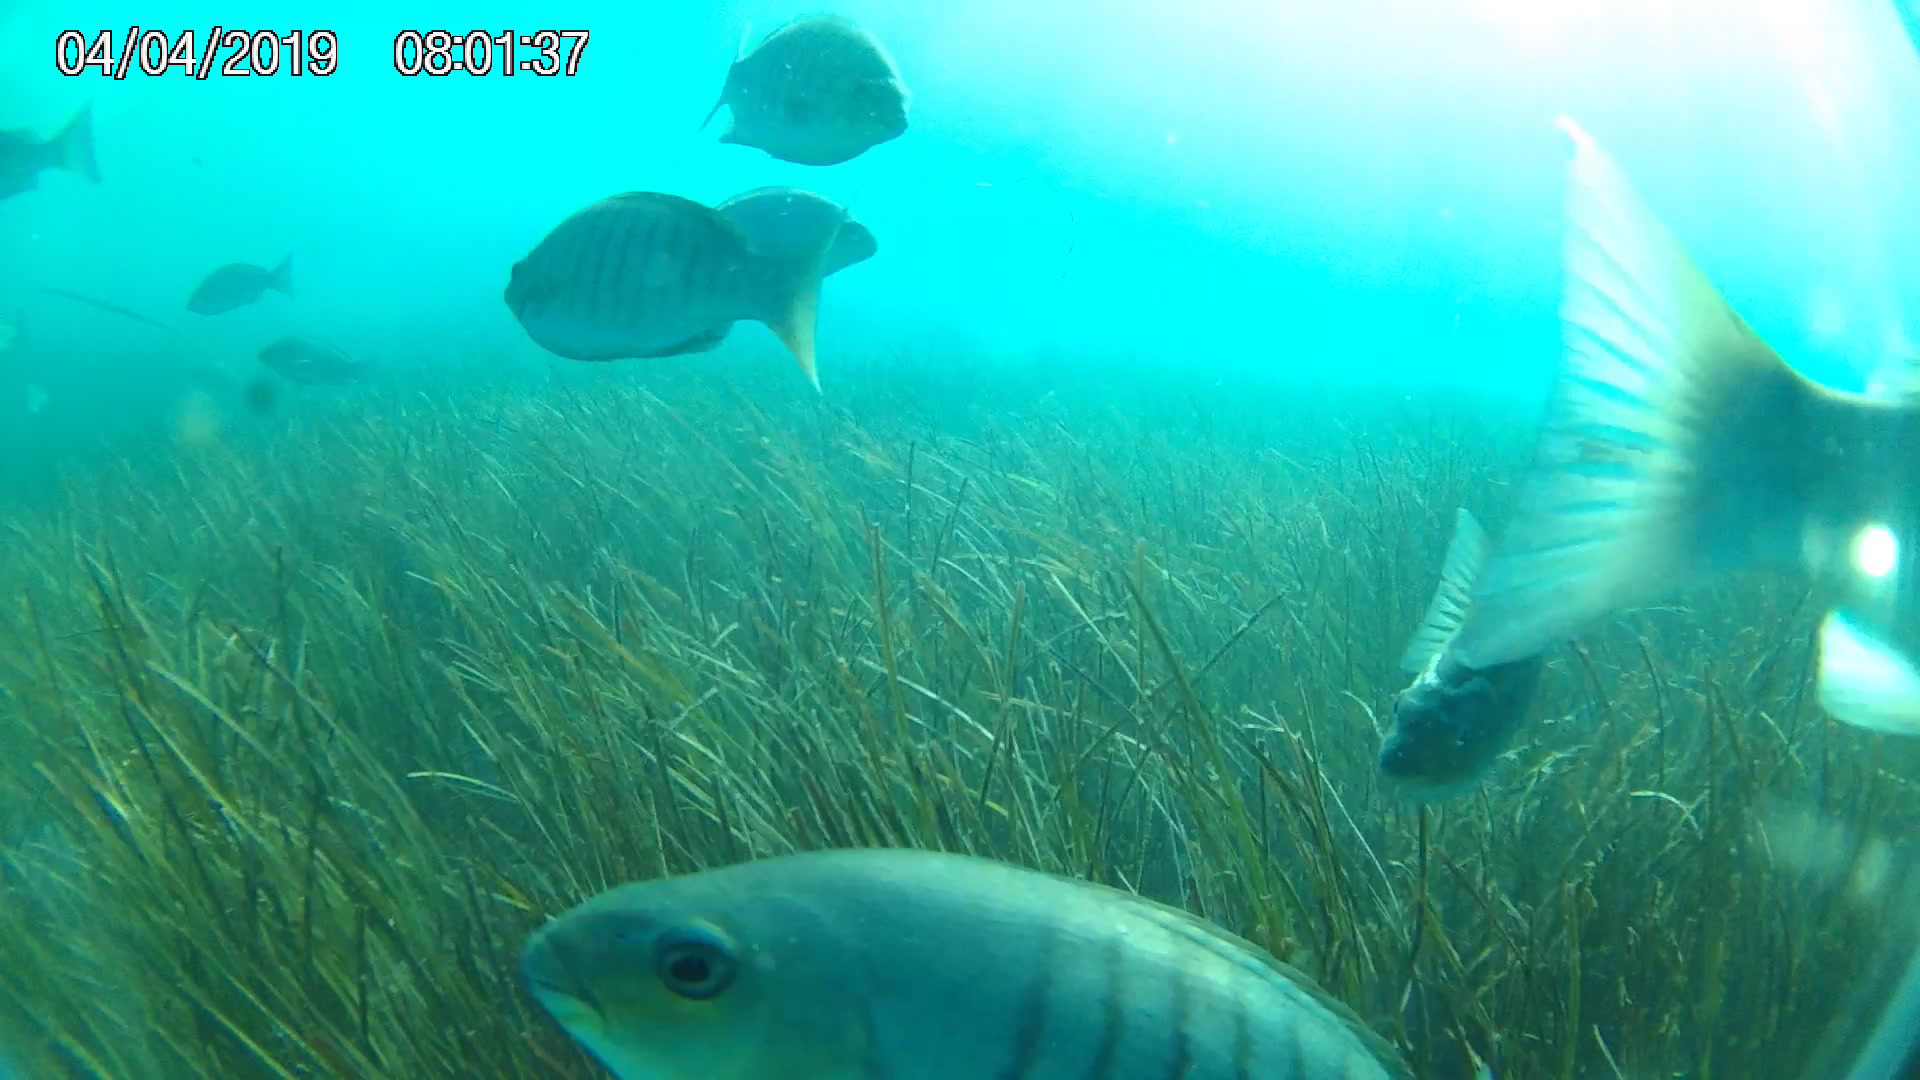

In [45]:
img

In [46]:
img.save("pedo.jpg")

In [47]:
ima = Image.open("pedo.jpg").convert("RGB")

In [50]:
np.array(img)

array([[[  0, 237, 229],
        [  0, 237, 229],
        [  0, 237, 229],
        ...,
        [108, 255, 255],
        [108, 255, 255],
        [107, 255, 255]],

       [[  0, 237, 229],
        [  0, 237, 229],
        [  0, 237, 229],
        ...,
        [108, 255, 255],
        [108, 255, 255],
        [106, 255, 255]],

       [[  0, 237, 229],
        [  0, 237, 229],
        [  0, 237, 229],
        ...,
        [106, 255, 255],
        [106, 255, 255],
        [106, 255, 255]],

       ...,

       [[ 19, 139, 137],
        [ 20, 140, 138],
        [ 21, 141, 139],
        ...,
        [ 16,  66,  57],
        [ 17,  67,  58],
        [ 17,  67,  56]],

       [[ 19, 139, 137],
        [ 20, 140, 138],
        [ 21, 141, 139],
        ...,
        [ 16,  66,  57],
        [ 17,  67,  58],
        [ 17,  67,  56]],

       [[ 19, 139, 137],
        [ 20, 140, 138],
        [ 21, 141, 139],
        ...,
        [ 16,  66,  57],
        [ 17,  67,  58],
        [ 17,  67,  56]]

In [68]:
patho = os.path.join(IMAGES_DIR, row['image_name'])

In [69]:
patho

'Fish_automated_identification_and_counting\\luderick-seagrass\\04C1_Luderick_2.mov_5fps_000089.jpg'

In [70]:
!copy {patho} datasets\pipi.jpg

        1 archivo(s) copiado(s).


In [67]:
IMAGES_DIR

'Fish_automated_identification_and_counting\\luderick-seagrass'

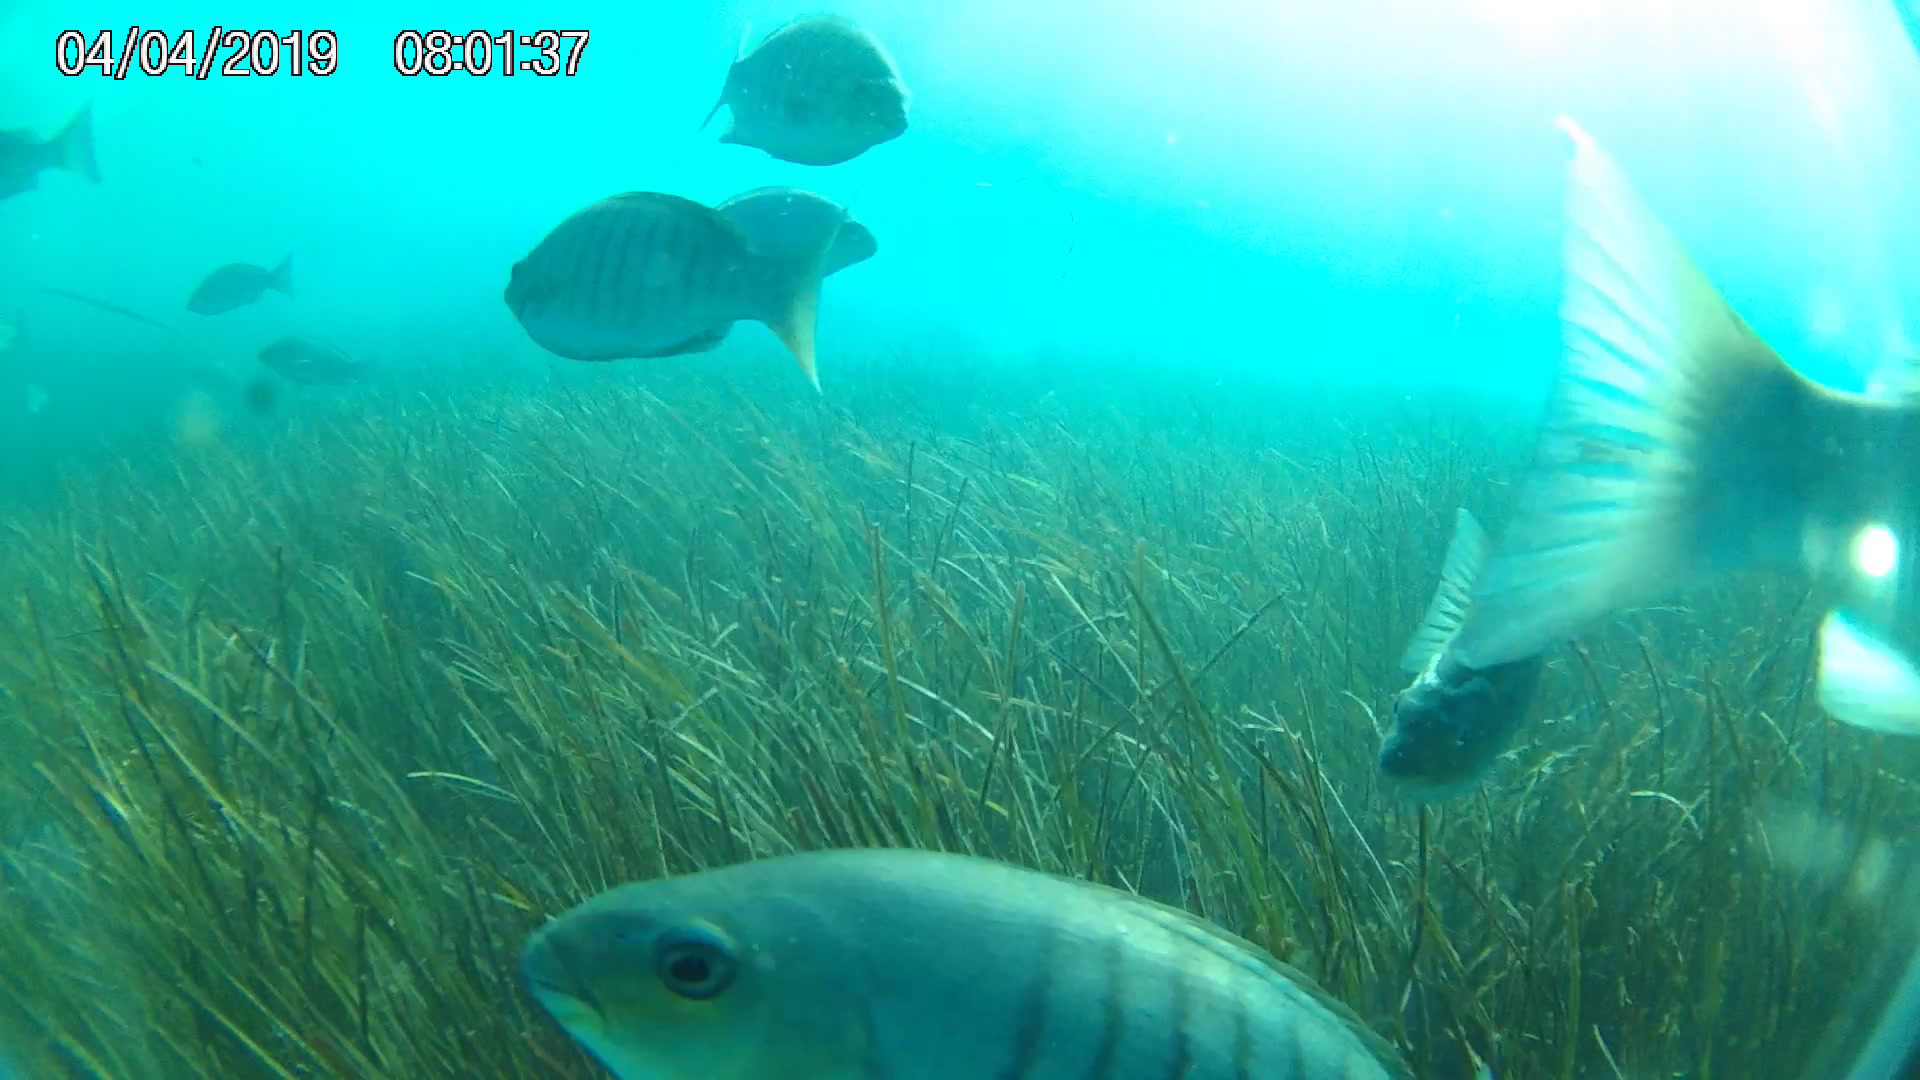

In [71]:
Image.open(patho)